In [1]:
import os, sys, importlib, random; import xarray as xr; 
import pandas as pd; import matplotlib.pyplot as plt
import numpy as np; 
sys.path.append('/mnt/sda1/PhysOc/modview/modview/');
import loader, viztools
img_dir = '/home/noel/Documents/Research/AQDP/proc_figs/'

The procedure here is very straightforward (because the codebase in load_aqdp.py is strong!). Begin by importing module and loading raw aqdp data (profiles taken at 1 Hz), then create ensemble set.

In [2]:
import load_aqdp
importlib.reload(load_aqdp)
raw_dat = load_aqdp.build_raw()
dt_seconds = 30;
# Create ensemble set
ens = load_aqdp.Ensembles(dt_seconds, raw_dat)

Will process 6791 ensembles lasting 30 s each.


In [3]:
importlib.reload(load_aqdp)
veron = load_aqdp.Veron(ens); 
wiles = load_aqdp.Wiles(ens); 

The fitting range for the structure function method is [0.1326 0.5746] meters


In [4]:
motion = load_aqdp.vehicle_motion(ens)
motion.vertical_velocity(135)
ens.time[135]

datetime.datetime(2015, 1, 13, 8, 26, 30)

In [5]:
import aqdp_errors
importlib.reload(aqdp_errors)

indices = [random.randrange(0,3000) for kk in range(100)]
veron_table = aqdp_errors.make_table( veron, indices )
wiles_table = aqdp_errors.make_table( wiles, indices )

/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex 

/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex 

/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex 

In [11]:
cake = np.array([3+1j, 5+6j])

In [15]:
np.real(cake*np.conj(cake))

array([10., 61.])

Text(0, 0.5, 'log(epsilon) - Veron')

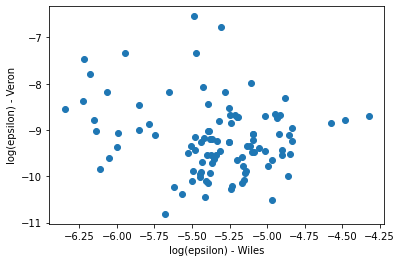

In [10]:
plt.scatter( np.log10(wiles_table['epsilon']), 
                      np.log10(veron_table['epsilon']))
#plt.scatter( vert_vel, ), label='Wiles method' )
plt.xlabel('log(epsilon) - Wiles')
plt.ylabel('log(epsilon) - Veron')

In [37]:
ens.get_pressure()[[200,300]]

<xarray.DataArray (time: 2)>
array([995.3574    , 882.51355172])
Coordinates:
  * time     (time) datetime64[ns] 2015-01-13T09:07:30 2015-01-13T10:14:30

Create instances of the Veron and Wiles methods using the set of ensembles we just created. Choose a random ensemble and plot results using both methods.

The fitting range for the structure function method is [0.1326 0.5746] meters


/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


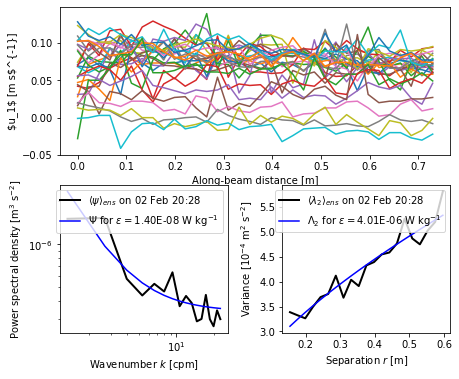

In [4]:


index = random.randint(0, len(ens.time)-1);
fig_dict = {'figsize':[7,6],'widths':[1,0.05,1],'heights':[1,1],
           'panels':([0,slice(0,3)],[1,0],[1,2])}
fig = viztools.panel_plot(fig_dict); fig.draw(); 

vels = ens.see_member(index)
fig.axes[0].plot( vels.length, vels.transpose() )
fig.axes[0].set_ylabel(r'$u_1$ [m s$^{-1}]'); 
fig.axes[0].set_xlabel('Along-beam distance [m]')
veron.plot_obs_theory( fig.axes[1], index )
fig.axes[1].legend()
wiles.plot_obs_theory( fig.axes[2], index )
fig.axes[2].legend()

In [5]:
# Plot the cost function for a given index
index = 440;
observ = veron.observations_curve(index);
degfred = observ.shape[0];
observ = np.mean(observ,axis=0);
eps_trial = 10**(np.arange(-10,-6,0.1))
floor_trial = 10**(np.arange(-8,-6,0.04))
cost = np.zeros( (len(eps_trial), len(floor_trial)) )
for kk in range(len(eps_trial)):
    for jj in range(len(floor_trial)):
        parameters = [eps_trial[kk], floor_trial[jj]]
        cost[kk,jj] = veron.cost_function(parameters, 
                            observ, degfred)


/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


<ipython-input-30-6b7068414b89>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = plt.pcolormesh( np.log10(eps_trial), np.log10(floor_trial),


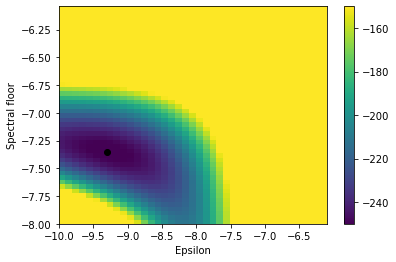

In [30]:
solution = veron.estimate_epsilon( index );

img = plt.pcolormesh( np.log10(eps_trial), np.log10(floor_trial), 
               cost.transpose(), vmin=-250, vmax=-150)
plt.scatter( np.log10(solution[0]), np.log10(solution[1]), color='black')
plt.xlabel('Epsilon'); plt.ylabel('Spectral floor')
plt.colorbar(img)

The fitting range for the structure function method is [0.0884 0.5525] meters
[4.14818033e-06 1.46096118e-04]


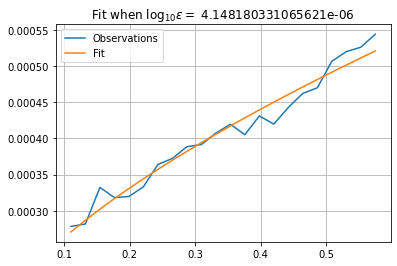

In [7]:
index = 1132

wil_1 = load_aqdp.Wiles(ens_1, detrend=False, beam='v1')
solution = wil_1.estimate_epsilon(index)

cake = wil_1.observations_curve( index )
plt.plot( wil_1.l_fit, np.mean(cake,axis=0), label='Observations' );
sf_theory = wil_1.theory_curve( wil_1.l_fit, solution[0], solution[1] )
plt.plot( wil_1.l_fit, sf_theory, label='Fit' )
plt.title(r'Fit when $\log_{10} \varepsilon =$ '+str(solution[0]))
plt.legend(); plt.grid(which='both')
print(solution)

In [6]:
raw_dat

<xarray.Dataset>
Dimensions:   (length: 34, time: 199002)
Coordinates:
  * time      (time) datetime64[ns] 2015-01-13T06:42:37.000001 ... 2015-01-17...
  * length    (length) float64 0.2 0.2221 0.2442 0.2663 ... 0.8851 0.9072 0.9293
Data variables:
    v1        (time, length) float64 -0.069 -0.084 -0.082 ... -0.186 -0.187
    v2        (time, length) float64 -0.134 -0.145 -0.144 ... 0.003 0.032 0.035
    v3        (time, length) float64 -0.023 -0.024 -0.023 ... -0.043 -0.046
    pitch     (time) float64 -8.2 -9.5 -11.0 -11.5 -11.0 ... 33.5 33.5 33.4 33.6
    roll      (time) float64 14.9 14.3 13.7 13.4 ... -13.9 -14.3 -14.8 -13.8
    hdg       (time) float64 128.8 132.9 137.2 135.9 ... 325.6 332.8 25.3 338.0
    dtnum     (time) float64 7.36e+05 7.36e+05 7.36e+05 ... 7.36e+05 7.36e+05
    pressure  (time) float64 1.13e+03 1.131e+03 1.131e+03 ... 1.07e+03 1.07e+03
    yday      (time) float64 12.28 12.28 12.28 12.28 ... 16.25 16.25 16.25 16.25

To see how this all works, we choose an index to identify a specific ensemble member, and then 
(1) compute the power spectrum for that observations in that ensemble
(2) compare spectrum to theoretical estimate given a value of epsilon

/home/noel/Documents/software/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


TypeError: theory_curve() missing 1 required positional argument: 'spec_floor'

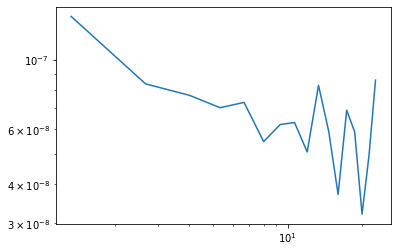

In [9]:
ind_list = 88
epsilon_value = 6e-10

spectra = ver_1.observations_curve(ind_list)

plt.loglog( ver_1.wvnums, np.mean( spectra.transpose(), axis=1) )
plt.loglog( ver_1.wvnums, ver_1.theory_curve(epsilon_value))
plt.loglog( ver_1.wvnums, 1e-6*ver_1.wvnums**(-2/3)) # compare to -2/3 slope
plt.ylim([1e-9,1e-6]); plt.grid(which='both')
plt.title('Spectral method, time = ' + str(ens_1.time[ind_list]))
plt.legend(['Observational spectrum',r'Theory, $\varepsilon =$'+str(epsilon_value),'-2/3 slope'])
print( ver_1.cost_function(epsilon_value, ind_list))
plt.hlines(ver_1.noise,1,20, color='black')
plt.savefig(img_dir+'obs_vs_theory.jpg',dpi=200)

In [ ]:
cake = np.arange(4,10,0.4);
isinstance(cake,iter)

In [ ]:
fig_dict = {'figsize':[6,10],'widths':[1,0.05], 'heights':[1,1,1],
            'panels':([0,0],[1,0],[2,0]) }
fig = viztools.panel_plot(fig_dict);
fig_limits = {'t0':'2013-01-22', 't1':'2013-01-27', 
              'z0':850, 'z1':1150};

u_settings = {'vmin':-0.3, 'vmax':0.3, 'cmap':'bwr'}
cont_settings = {'levels':np.arange(2,7,0.5),'colors':'gray',
                'linewidth':0.5}

fig.draw()
u_plot = make_pcolor( fig.axes[0], 'u', fig_limits, u_settings);

th_cont = make_contour(fig.axes[0],'th', fig_limits, cont_settings)

In [ ]:
cake = cut_grid_var(grid_dat['u'],fig_limits)

In [ ]:
def shear_squared():
    sh2 = grid_dat['u'].differentiate(coord='pressure')**2 \
            + grid_dat['v'].differentiate(coord='pressure')**2;
    return sh2



In [ ]:
sh2 = shear_squared().sel(time=slice('2013-02-01',
        '2013-03-04'))
sh2 = sh2.resample(time='3H').mean()
sh2.plot(vmin=0, vmax=5e-5,figsize=[10,6])

In [ ]:
raw_dat['yday'].shape